#  Прогнозирование заказов такси

Проект азработан для компании "Чётенькое такси" с целью привлечения большего количества водителей в период пиковой нагрузки. 

**Цель проекта**: построить модел, которая спрогнозирует количество заказов такси на следующий час на основе исторических данных о заказах в аэропортах. Основной метрикой для оценки модели является RMSE, значение которой на тестовой выборке не должно превышать 48.

**Описание данных**:
Компания подготовила исторические данные о заказах такси в аэропортах. Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-данных-и-библиотек" data-toc-modified-id="Импорт-данных-и-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт данных и библиотек</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Первичное-изучение-данных" data-toc-modified-id="Первичное-изучение-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Первичное изучение данных</a></span></li><li><span><a href="#Декомпозиция-временного-ряда" data-toc-modified-id="Декомпозиция-временного-ряда-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Декомпозиция временного ряда</a></span></li><li><span><a href="#Проверка-на-стационарность" data-toc-modified-id="Проверка-на-стационарность-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Проверка на стационарность</a></span></li></ul></li><li><span><a href="#Подготовка-данных-к-обучению" data-toc-modified-id="Подготовка-данных-к-обучению-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных к обучению</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Обучение-моделей-без-оптимизации" data-toc-modified-id="Обучение-моделей-без-оптимизации-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Обучение моделей без оптимизации</a></span></li><li><span><a href="#Оптимизация-гиперпараметров" data-toc-modified-id="Оптимизация-гиперпараметров-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Оптимизация гиперпараметров</a></span></li></ul></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span><ul class="toc-item"><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li></ul></div>

## Импорт данных и библиотек

Импортируем все необходимые библиотеки. 

In [1]:
import os
import time
import pandas as pd
import numpy as np
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [2]:
if os.path.exists('.../taxi.csv'):
    df = pd.read_csv('.../TimeSeries/taxi.csv', index_col=[0], parse_dates=[0])
else:
    df = pd.read_csv('.../taxi.csv', index_col=[0], parse_dates=[0])

## Анализ

### Первичное изучение данных

Посмотрим на данные.

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
df.isnull().sum()

num_orders    0
dtype: int64

Проверим хронологически ли расположены даты и время.

In [7]:
print(df.index.is_monotonic)

True


- В нашем распоряжении есть датасет из 26496 значений
- В датасете содержатся данные с 1 марта 2018 по 31 августа 2018 без пропусков.
- Данные расположены в хронологическом порядке
- Среднее значение количества заказов такси составляет около 14, при стандартном отклонении около 9.Минимальное значение количества заказов равно 0, а максимальное - 119. Временной интервал между записями составляет 10 минут.

Чтобы сгладить данные и улучшить эффективность модели, ресемплируем данные по 1 часу. После чего посмотрим как визуально выглядит распределение количества заказов на гистограмме.

In [8]:
df = df.resample('1H').sum()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df['num_orders'], nbinsx=50))
fig.update_layout(
    title="Количество заказов в час",
    xaxis_title="Num_orders",
    yaxis_title="Frequency",
    bargap=0.1,
)

fig.show()

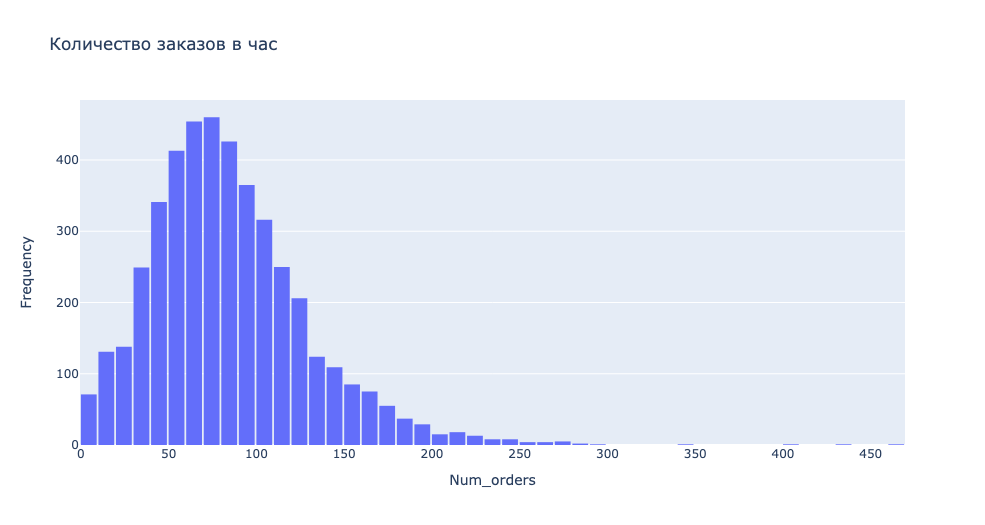

Распределение заказов смещено вправо и имеет длинный правый хвост. Большинство заказов сосредоточены вокруг среднего значения, но есть некоторое количество значений, которые сильно превышают среднее значение и могут быть аномальными. Это предсказуемо, так как могут быть дни с увеличенным количеством заказов такси.

Изучим временные ряды.

In [ ]:
pyo.init_notebook_mode(connected=True)
trace = go.Scatter(x=df.index, y=df['num_orders'], mode='lines', name='Количество заказов такси')
layout = go.Layout(title='Количество заказов такси с марта по август 2018',
                   xaxis=dict(title='Дата'),
                   yaxis=dict(title='Количество заказов такси'))

fig = go.Figure(data=[trace], layout=layout)
pyo.iplot(fig)

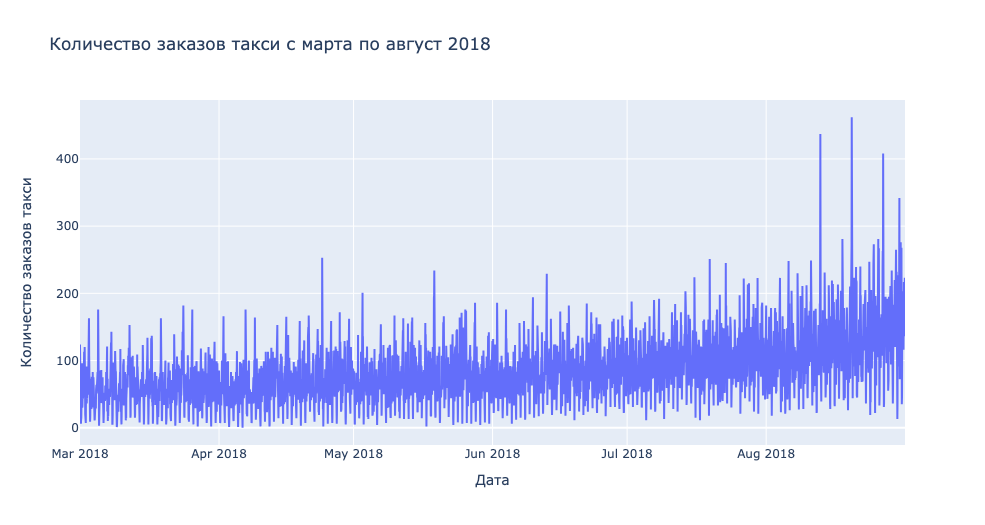

### Декомпозиция временного ряда 

Декомпозируем временной ряд на тренд, сезонность и шум.

In [11]:
decomposition = seasonal_decompose(df['num_orders'], model='additive', period=24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [ ]:
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# график изначальных данных
fig.add_trace(go.Scatter(x=df.index, y=df['num_orders'], name='Оригинальные данные', showlegend=True), row=1, col=1)

# график тренда
fig.add_trace(go.Scatter(x=trend.index, y=trend, name='Тренд', showlegend=True), row=2, col=1)

# сезонность
fig.add_trace(go.Scatter(x=seasonal.index, y=seasonal, name='Сезонность', showlegend=True), row=3, col=1)

# остатки
fig.add_trace(go.Scatter(x=residual.index, y=residual, name='Шум', showlegend=True), row=4, col=1)


fig.update_layout(height=800, width=1000, title_text="Декомпозиция временного ряда на тренд, сезонность и шум",
                  xaxis=dict(title='Date'))

fig.update_yaxes(title_text='Оригинальный ряд', row=1, col=1)
fig.update_yaxes(title_text='Тренд', row=2, col=1)
fig.update_yaxes(title_text='Сезонность', row=3, col=1)
fig.update_yaxes(title_text='Шум', row=4, col=1)

fig.show()

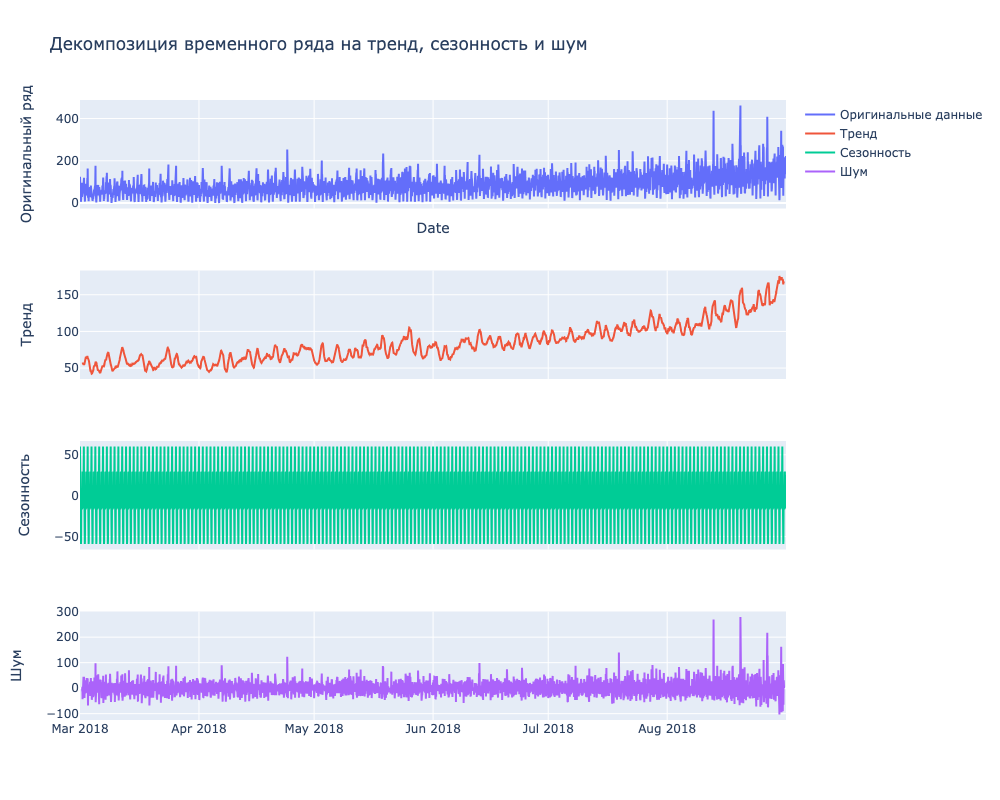

Видим в данные возрастающий тренд и суточную сезонность. Посмотрим на сезонность поближе.

In [ ]:
seven_days = seasonal[:7 * 24]


fig = go.Figure()
fig.add_trace(go.Scatter(x=seven_days.index, y=seven_days, name='Сезонность'))

fig.update_layout(height=600, width=1000, title_text="Сезонность временного ряда (7 дней)",
                  xaxis=dict(title='Дата'), yaxis=dict(title='Сезонность'))

fig.show()

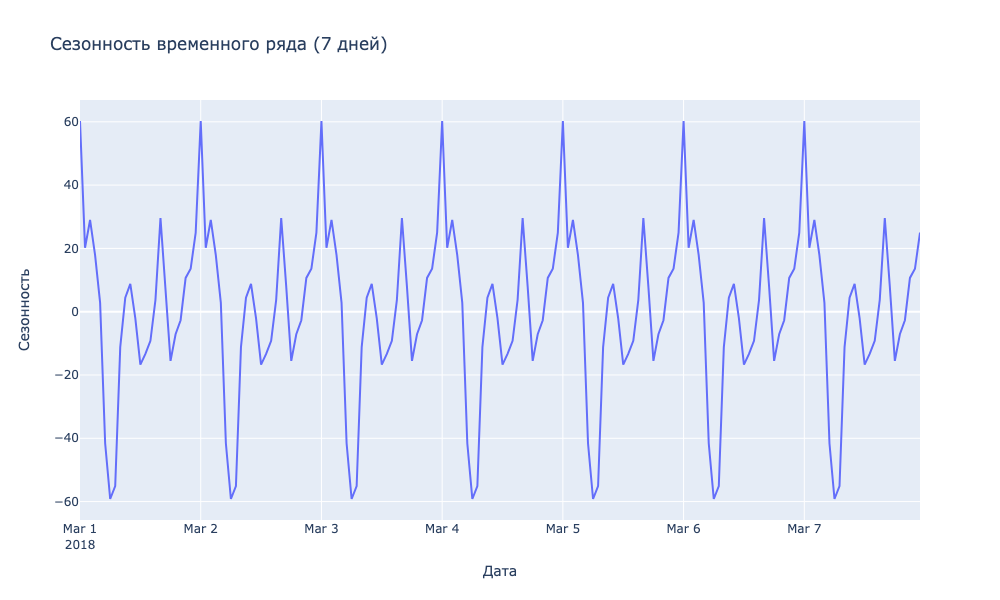

Видим явно выраженную суточную сезонность. Пик заказов такси приходится на полночь, к 6 утра наблюдается максимальны спад. Затем спрос повышается с двумя пиками — в 10.00 и 16.00.

###  Проверка на стационарность

Вычислим скользящее среднее и скользящее стандартное отклонение, чтобы визуально оценить стационарность.

In [14]:
window_size = 48
rolling_mean = df['num_orders'].rolling(window=window_size).mean()
rolling_std = df['num_orders'].rolling(window=window_size).std()


fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['num_orders'], name='Временной ряд'))
fig.add_trace(go.Scatter(x=df.index, y=rolling_mean, name='Скользящее среднее'))
fig.add_trace(go.Scatter(x=df.index, y=rolling_std, name='Среднее стандартное отклонение'))


fig.update_layout(height=600, width=1000, title_text="Временной ряд, скользящее среднее и среднее стандартное отклонение",
                  xaxis=dict(title='Дата'), yaxis=dict(title='Количество заказов'))

fig.show()

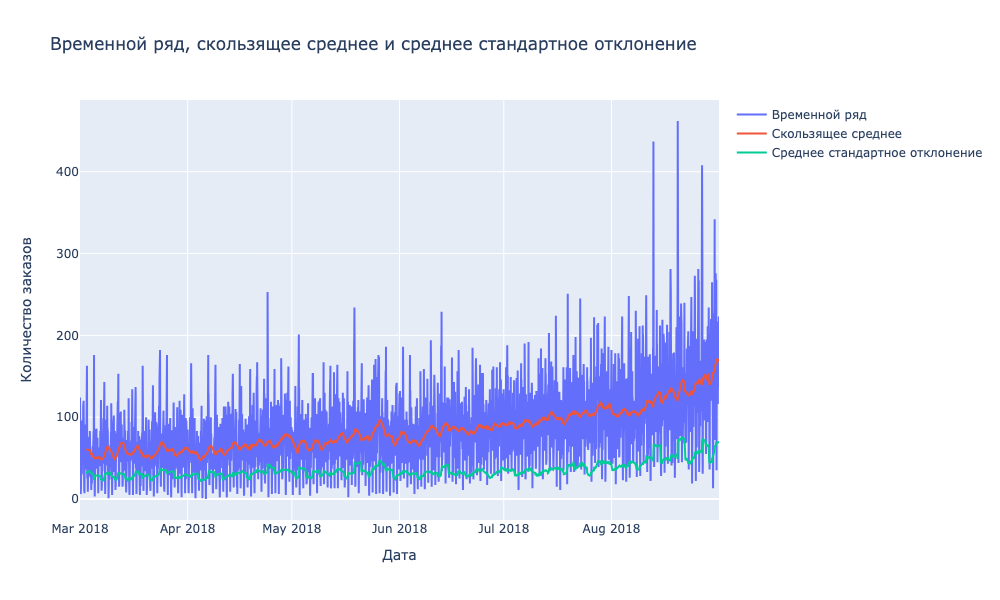

Проведем тест Дики-Фуллера для оценки стационарности ряда.

In [15]:
dickey_fuller = adfuller(df['num_orders'])


print('Статистика ADF: {:.4f}'.format(dickey_fuller[0]))
print('P-valeu: {:.4f}'.format(dickey_fuller[1]))
print('Критические значения:')
for key, value in dickey_fuller[4].items():
    print('\t{}: {:.4f}'.format(key, value))

Статистика ADF: -3.0689
P-valeu: 0.0289
Критические значения:
	1%: -3.4318
	5%: -2.8622
	10%: -2.5671


- Статистика `ADF` -3.0689 меньше 0 и меньше критического значения 5%, что указывает на то, что временной ряд стационарен.
- `p-value` 0.0289. В данном случае, p-значение, которое представляет вероятность того, что ряд нестационарен. Так как значение p-valeu меньше 0.05, это свидетелсьвтует в пользу того, что временной ряд стационарен.

В целом, тест Дики-Фуллера позволяет заключить, что данные временной ряд является стационарным с уровнем значимости 5%. Хотя визуально мы видим вомходящий тренд, будем относиться к ряду как к стационарному и делать предсказании на этом основании.

## Подготовка данных к обучению

Добавим модели новые признаки и разделим выборки на тренировочную, валидационную и тестовую. А также напишем удобную функцию для быстрого обуения моделей.

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    
    new_data['hour'] = new_data.index.hour
    new_data['day_of_week'] = new_data.index.dayofweek
    new_data['day_of_month'] = new_data.index.day
    new_data['month'] = new_data.index.month

    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)
        
    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return new_data.dropna()


df_features = make_features(df, max_lag=24, rolling_mean_size=24)


In [17]:
df_features.head(5)

,num_orders,hour,day_of_week,day_of_month,month,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,2,3,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,1,4,2,3,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,2,4,2,3,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,3,4,2,3,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,4,4,2,3,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


Разделим выборки в пропорции 80%, 10%, 10%

In [18]:
X = df_features.drop('num_orders', axis=1)
y = df_features['num_orders']


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, shuffle=False, test_size=0.5, random_state=42)


In [19]:
print("Размеры обучающей выборки: ", X_train.shape, y_train.shape)
print("Размеры валидационной выборки: ", X_valid.shape, y_valid.shape)
print("Размеры тестовой выборки: ", X_test.shape, y_test.shape)

Размеры обучающей выборки:  (3513, 29) (3513,)
Размеры валидационной выборки:  (439, 29) (439,)
Размеры тестовой выборки:  (440, 29) (440,)


Проверим, что даты идут в правильном порядке

In [20]:
print(X_train.index.min(), X_train.index.max())
print(X_valid.index.min(), X_valid.index.max())
print(X_test.index.min(), X_test.index.max())

2018-03-02 00:00:00 2018-07-26 08:00:00
2018-07-26 09:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


Напишем функцию, которая будет обучать модель и замерять скорость обучения и предсказания.

In [21]:
def train_pred(model_class, model_name, params=None):
    if params is not None:
        model = model_class(**params)
    else:
        model = model_class()

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    start_time = time.time()
    pred = model.predict(X_valid)
    pred_time = time.time() - start_time

    rmse = mse(y_valid, pred, squared=False)
    print('Модель:', model_name)
    print(f"RMSE модели на валидационной выборке: {rmse:.3f}")
    print(f"Время обучения: {train_time:.3f} сек.")
    print(f"Время предсказания: {pred_time:.3f} сек.")


## Обучение моделей

### Обучение моделей без оптимизации

Обучим модели без оптимизации гиперпараметров.

In [22]:
train_pred(LinearRegression, "Линейная регрессия")

Модель: Линейная регрессия
RMSE модели на валидационной выборке: 34.228
Время обучения: 0.010 сек.
Время предсказания: 0.002 сек.


In [23]:
train_pred(RandomForestRegressor, "Random Forest")

Модель: Random Forest
RMSE модели на валидационной выборке: 32.331
Время обучения: 3.626 сек.
Время предсказания: 0.011 сек.


In [24]:
train_pred(XGBRegressor, 'XGBRegressor')

Модель: XGBRegressor
RMSE модели на валидационной выборке: 33.055
Время обучения: 0.325 сек.
Время предсказания: 0.004 сек.


In [25]:
train_pred(LGBMRegressor, 'LGBMRegressor')

Модель: LGBMRegressor
RMSE модели на валидационной выборке: 31.850
Время обучения: 0.266 сек.
Время предсказания: 0.002 сек.


In [26]:
train_pred(CatBoostRegressor, 'CatBoostRegressor')

Learning rate set to 0.049934
0:	learn: 34.9528130	total: 65.2ms	remaining: 1m 5s
1:	learn: 34.1630739	total: 67.9ms	remaining: 33.9s
2:	learn: 33.4466513	total: 69.7ms	remaining: 23.2s
3:	learn: 32.7591918	total: 71.7ms	remaining: 17.8s
4:	learn: 32.1081086	total: 73.3ms	remaining: 14.6s
5:	learn: 31.4542285	total: 74.9ms	remaining: 12.4s
6:	learn: 30.8879872	total: 76.8ms	remaining: 10.9s
7:	learn: 30.3617000	total: 78.5ms	remaining: 9.73s
8:	learn: 29.8879823	total: 80.7ms	remaining: 8.88s
9:	learn: 29.4089912	total: 82.8ms	remaining: 8.2s
10:	learn: 28.9797011	total: 84.7ms	remaining: 7.62s
11:	learn: 28.5264612	total: 86.6ms	remaining: 7.13s
12:	learn: 28.1428697	total: 88.4ms	remaining: 6.71s
13:	learn: 27.7902312	total: 90.3ms	remaining: 6.36s
14:	learn: 27.4582286	total: 92.1ms	remaining: 6.05s
15:	learn: 27.1647010	total: 94ms	remaining: 5.78s
16:	learn: 26.8550948	total: 96.2ms	remaining: 5.56s
17:	learn: 26.5083254	total: 98.5ms	remaining: 5.37s
18:	learn: 26.2447983	total: 

157:	learn: 18.9372260	total: 344ms	remaining: 1.83s
158:	learn: 18.9204800	total: 346ms	remaining: 1.83s
159:	learn: 18.9114258	total: 348ms	remaining: 1.83s
160:	learn: 18.8821984	total: 350ms	remaining: 1.82s
161:	learn: 18.8646699	total: 352ms	remaining: 1.82s
162:	learn: 18.8343592	total: 353ms	remaining: 1.81s
163:	learn: 18.8138308	total: 355ms	remaining: 1.81s
164:	learn: 18.7979746	total: 357ms	remaining: 1.81s
165:	learn: 18.7785100	total: 359ms	remaining: 1.8s
166:	learn: 18.7438420	total: 361ms	remaining: 1.8s
167:	learn: 18.7196613	total: 363ms	remaining: 1.8s
168:	learn: 18.7054216	total: 364ms	remaining: 1.79s
169:	learn: 18.6925028	total: 366ms	remaining: 1.79s
170:	learn: 18.6822180	total: 368ms	remaining: 1.78s
171:	learn: 18.6695632	total: 370ms	remaining: 1.78s
172:	learn: 18.6589958	total: 372ms	remaining: 1.78s
173:	learn: 18.6500224	total: 373ms	remaining: 1.77s
174:	learn: 18.6349494	total: 375ms	remaining: 1.77s
175:	learn: 18.6174981	total: 377ms	remaining: 1.

386:	learn: 15.2014915	total: 739ms	remaining: 1.17s
387:	learn: 15.1837483	total: 741ms	remaining: 1.17s
388:	learn: 15.1730480	total: 743ms	remaining: 1.17s
389:	learn: 15.1636021	total: 744ms	remaining: 1.16s
390:	learn: 15.1548002	total: 746ms	remaining: 1.16s
391:	learn: 15.1349594	total: 748ms	remaining: 1.16s
392:	learn: 15.1167802	total: 749ms	remaining: 1.16s
393:	learn: 15.1048844	total: 751ms	remaining: 1.16s
394:	learn: 15.0910325	total: 753ms	remaining: 1.15s
395:	learn: 15.0703586	total: 755ms	remaining: 1.15s
396:	learn: 15.0584365	total: 757ms	remaining: 1.15s
397:	learn: 15.0432482	total: 759ms	remaining: 1.15s
398:	learn: 15.0411945	total: 761ms	remaining: 1.15s
399:	learn: 15.0403206	total: 762ms	remaining: 1.14s
400:	learn: 15.0202583	total: 764ms	remaining: 1.14s
401:	learn: 15.0098826	total: 766ms	remaining: 1.14s
402:	learn: 14.9975741	total: 768ms	remaining: 1.14s
403:	learn: 14.9799188	total: 769ms	remaining: 1.13s
404:	learn: 14.9685038	total: 771ms	remaining:

617:	learn: 12.7807540	total: 1.13s	remaining: 699ms
618:	learn: 12.7798620	total: 1.13s	remaining: 697ms
619:	learn: 12.7696540	total: 1.13s	remaining: 695ms
620:	learn: 12.7603570	total: 1.14s	remaining: 693ms
621:	learn: 12.7503823	total: 1.14s	remaining: 691ms
622:	learn: 12.7399614	total: 1.14s	remaining: 690ms
623:	learn: 12.7252354	total: 1.14s	remaining: 688ms
624:	learn: 12.7140555	total: 1.14s	remaining: 686ms
625:	learn: 12.7017410	total: 1.15s	remaining: 684ms
626:	learn: 12.6949516	total: 1.15s	remaining: 682ms
627:	learn: 12.6886840	total: 1.15s	remaining: 680ms
628:	learn: 12.6822194	total: 1.15s	remaining: 679ms
629:	learn: 12.6752821	total: 1.15s	remaining: 677ms
630:	learn: 12.6620087	total: 1.15s	remaining: 675ms
631:	learn: 12.6569084	total: 1.16s	remaining: 674ms
632:	learn: 12.6475612	total: 1.16s	remaining: 672ms
633:	learn: 12.6413564	total: 1.16s	remaining: 670ms
634:	learn: 12.6235704	total: 1.16s	remaining: 668ms
635:	learn: 12.6133982	total: 1.16s	remaining:

833:	learn: 10.9991592	total: 1.53s	remaining: 304ms
834:	learn: 10.9880466	total: 1.53s	remaining: 302ms
835:	learn: 10.9876684	total: 1.53s	remaining: 300ms
836:	learn: 10.9783309	total: 1.53s	remaining: 298ms
837:	learn: 10.9720918	total: 1.53s	remaining: 296ms
838:	learn: 10.9607602	total: 1.53s	remaining: 295ms
839:	learn: 10.9541853	total: 1.54s	remaining: 293ms
840:	learn: 10.9445097	total: 1.54s	remaining: 291ms
841:	learn: 10.9337621	total: 1.54s	remaining: 289ms
842:	learn: 10.9224464	total: 1.54s	remaining: 287ms
843:	learn: 10.9163527	total: 1.54s	remaining: 285ms
844:	learn: 10.9117580	total: 1.54s	remaining: 283ms
845:	learn: 10.9044803	total: 1.55s	remaining: 282ms
846:	learn: 10.8932001	total: 1.55s	remaining: 280ms
847:	learn: 10.8856522	total: 1.55s	remaining: 278ms
848:	learn: 10.8750156	total: 1.55s	remaining: 276ms
849:	learn: 10.8667115	total: 1.55s	remaining: 274ms
850:	learn: 10.8568673	total: 1.55s	remaining: 272ms
851:	learn: 10.8489677	total: 1.56s	remaining:

### Оптимизация гиперпараметров

Для временных рядов лучше использовать `TimeSeriesSplit` вместо обычной кросс-валидации, так как это учитывает временную структуру данных и предотвращает утечку информации из будущего.

In [27]:
tscv = TimeSeriesSplit(n_splits=5)

Для оптимизации гиперпараметров в этом проекте попробуем использвать `Bayesian Optimization`. В теории, этот метод может обеспечить более точные результаты и потребует меньше времени, чем `Grid Search` и `Random Search`. Ограничим поиск 10 иттерациями, чтобы модели обучались быстрее.

In [28]:
%%time
param_space = {
    'fit_intercept': [True, False],
    'copy_X':[True, False],
}

lr = LinearRegression()

bayes_search = BayesSearchCV(
    estimator=lr,
    search_spaces=param_space,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_iter=4,  
    n_jobs=-1,
    verbose=2,
    random_state=42
)

bayes_search.fit(X_train, y_train)
best_lr = bayes_search.best_estimator_
best_params_lr = bayes_search.best_params_

best_params_lr

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 97.8 ms, sys: 182 ms, total: 280 ms
Wall time: 3.38 s


OrderedDict([('copy_X', False), ('fit_intercept', True)])

In [29]:
%%time
train_pred(LinearRegression, "Линейная регрессия оптимизированная", best_params_lr)

Модель: Линейная регрессия оптимизированная
RMSE модели на валидационной выборке: 34.228
Время обучения: 0.004 сек.
Время предсказания: 0.001 сек.
CPU times: user 17.4 ms, sys: 4.95 ms, total: 22.4 ms
Wall time: 5.44 ms


В линейной регрессии перебирать особо нечего, поэтому неудивительно, что резальтаты не удалось улучшить. Но попробуем сделать тоже самое с другими моделями.

In [30]:
%%time
#обучим RandomForestRegressor
param_space = {
    'n_estimators': Integer(10, 1000),
    'max_depth': Integer(1, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Real(0.1, 1),
}

rf = RandomForestRegressor(random_state=42)

tscv = TimeSeriesSplit(n_splits=5)

bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_iter=10,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

bayes_search.fit(X_train, y_train)

best_rf = bayes_search.best_estimator_
best_params_rf = bayes_search.best_params_

print("Лучшие параметры для RandomForestRegressor:", best_params_rf)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Лучшие параметры для RandomForestRegressor: OrderedDict([('max_depth', 24), ('max_features', 0.4942262677968311), ('min_samples_leaf', 6), ('min_samples_split', 8), ('n_estimators', 905)])
CPU times: user 15 s, sys: 982 ms, total: 16 s
Wall time: 1min 48s


In [31]:
train_pred(RandomForestRegressor, "Random Forest Optimised",best_params_rf)

Модель: Random Forest Optimised
RMSE модели на валидационной выборке: 32.824
Время обучения: 12.577 сек.
Время предсказания: 0.083 сек.


In [32]:
%%time
param_space = {
    'n_estimators': Integer(10, 1000),
    'learning_rate': Real(1e-6, 1, prior='log-uniform'),
    'max_depth': Integer(1, 30),
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

tscv = TimeSeriesSplit(n_splits=5)

bayes_search = BayesSearchCV(
    estimator=xgb,
    search_spaces=param_space,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_iter=10,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

bayes_search.fit(X_train, y_train)

best_xgb = bayes_search.best_estimator_
best_params_xgb = bayes_search.best_params_

print("Лучшие параметры для XGBRegressor:", best_params_xgb)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Лучшие параметры для XGBRegressor: OrderedDict([('learning_rate', 0.07488174047459994), ('max_depth', 6), ('n_estimators', 602)])
CPU times: user 15.5 s, sys: 2.44 s, total: 17.9 s
Wall time: 1min 28s


In [33]:
train_pred(XGBRegressor, 'XGBRegressor Optimised',best_params_xgb)

Модель: XGBRegressor Optimised
RMSE модели на валидационной выборке: 31.831
Время обучения: 1.997 сек.
Время предсказания: 0.004 сек.


In [34]:
%%time
param_space = {
    'n_estimators': Integer(10, 1000),
    'learning_rate': Real(1e-6, 1, prior='log-uniform'),
    'max_depth': Integer(1, 30),
}

lgbm = LGBMRegressor(random_state=42)

bayes_search = BayesSearchCV(
    estimator=lgbm,
    search_spaces=param_space,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_iter=10,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

bayes_search.fit(X_train, y_train)

best_lgbm = bayes_search.best_estimator_
best_params_lgbm = bayes_search.best_params_

print("Лучшие параметры для LGBMRegressor:", best_params_lgbm)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Лучшие параметры для LGBMRegressor: OrderedDict([('learning_rate', 0.025361101250718457), ('max_depth', 28), ('n_estimators', 172)])
CPU times: user 3.71 s, sys: 747 ms, total: 4.46 s
Wall time: 8.79 s


In [35]:
train_pred(LGBMRegressor, 'LGBMRegressor optimised', best_params_lgbm)

Модель: LGBMRegressor optimised
RMSE модели на валидационной выборке: 32.305
Время обучения: 0.283 сек.
Время предсказания: 0.002 сек.


In [36]:
%%time
param_space = {
    'learning_rate': Real(1e-6, 1, prior='log-uniform'),
    'depth': Integer(1, 10),
    'l2_leaf_reg': Integer(2, 30),
    'border_count': Integer(1, 255),
    'bagging_temperature': Real(0.1, 1),
    'random_strength': Real(0.1, 1),
}

catboost = CatBoostRegressor(random_state=42, verbose=0)

tscv = TimeSeriesSplit(n_splits=5)

bayes_search = BayesSearchCV(
    estimator=catboost,
    search_spaces=param_space,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_iter=10,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

bayes_search.fit(X_train, y_train)

best_catboost = bayes_search.best_estimator_
best_params_catboost = bayes_search.best_params_

print("Лучшие параметры для CatBoostRegressor:", best_params_catboost)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Лучшие параметры для CatBoostRegressor: OrderedDict([('bagging_temperature', 0.8536495199979559), ('border_count', 225), ('depth', 4), ('l2_leaf_reg', 29), ('learning_rate', 0.15302679863863342), ('random_strength', 0.15608164675966435)])
CPU times: user 5.97 s, sys: 2.01 s, total: 7.98 s
Wall time: 1min 11s


In [37]:
%%time
train_pred(CatBoostRegressor, 'CatBoostRegressor optimised', best_params_catboost)

0:	learn: 33.5360421	total: 1.18ms	remaining: 1.18s
1:	learn: 31.6878941	total: 2.11ms	remaining: 1.05s
2:	learn: 30.2073719	total: 3.02ms	remaining: 1s
3:	learn: 28.9817510	total: 4.27ms	remaining: 1.06s
4:	learn: 27.9365089	total: 5.32ms	remaining: 1.06s
5:	learn: 26.9618874	total: 7.08ms	remaining: 1.17s
6:	learn: 26.2690933	total: 8.24ms	remaining: 1.17s
7:	learn: 25.7270613	total: 9.28ms	remaining: 1.15s
8:	learn: 25.2549519	total: 10.3ms	remaining: 1.13s
9:	learn: 24.7835839	total: 11.2ms	remaining: 1.11s
10:	learn: 24.4741370	total: 11.9ms	remaining: 1.07s
11:	learn: 24.2064593	total: 12.8ms	remaining: 1.05s
12:	learn: 23.9434646	total: 13.6ms	remaining: 1.03s
13:	learn: 23.7238154	total: 14.6ms	remaining: 1.03s
14:	learn: 23.5009185	total: 15.6ms	remaining: 1.02s
15:	learn: 23.3146766	total: 16.4ms	remaining: 1.01s
16:	learn: 23.1257860	total: 17.3ms	remaining: 1s
17:	learn: 22.9891216	total: 18.2ms	remaining: 991ms
18:	learn: 22.8344785	total: 19.1ms	remaining: 987ms
19:	learn

192:	learn: 18.1742784	total: 186ms	remaining: 779ms
193:	learn: 18.1514792	total: 187ms	remaining: 779ms
194:	learn: 18.1338572	total: 189ms	remaining: 779ms
195:	learn: 18.1140428	total: 190ms	remaining: 779ms
196:	learn: 18.0818444	total: 191ms	remaining: 778ms
197:	learn: 18.0642474	total: 192ms	remaining: 776ms
198:	learn: 18.0443213	total: 193ms	remaining: 775ms
199:	learn: 18.0358044	total: 193ms	remaining: 774ms
200:	learn: 18.0097872	total: 195ms	remaining: 773ms
201:	learn: 17.9837677	total: 196ms	remaining: 774ms
202:	learn: 17.9636162	total: 197ms	remaining: 774ms
203:	learn: 17.9552758	total: 198ms	remaining: 774ms
204:	learn: 17.9543275	total: 199ms	remaining: 773ms
205:	learn: 17.9367788	total: 200ms	remaining: 772ms
206:	learn: 17.9247272	total: 201ms	remaining: 771ms
207:	learn: 17.9211005	total: 202ms	remaining: 770ms
208:	learn: 17.9172205	total: 204ms	remaining: 770ms
209:	learn: 17.9168716	total: 205ms	remaining: 772ms
210:	learn: 17.9165344	total: 206ms	remaining:

395:	learn: 16.1935002	total: 382ms	remaining: 583ms
396:	learn: 16.1825496	total: 383ms	remaining: 582ms
397:	learn: 16.1815421	total: 384ms	remaining: 581ms
398:	learn: 16.1764312	total: 385ms	remaining: 580ms
399:	learn: 16.1677154	total: 386ms	remaining: 579ms
400:	learn: 16.1675050	total: 387ms	remaining: 578ms
401:	learn: 16.1590192	total: 388ms	remaining: 577ms
402:	learn: 16.1503949	total: 389ms	remaining: 576ms
403:	learn: 16.1376949	total: 390ms	remaining: 575ms
404:	learn: 16.1271429	total: 391ms	remaining: 574ms
405:	learn: 16.1269486	total: 392ms	remaining: 573ms
406:	learn: 16.1181962	total: 393ms	remaining: 572ms
407:	learn: 16.1144816	total: 394ms	remaining: 571ms
408:	learn: 16.1088071	total: 395ms	remaining: 570ms
409:	learn: 16.1081955	total: 396ms	remaining: 569ms
410:	learn: 16.1071562	total: 397ms	remaining: 568ms
411:	learn: 16.1066788	total: 397ms	remaining: 567ms
412:	learn: 16.1055829	total: 398ms	remaining: 566ms
413:	learn: 16.0940346	total: 399ms	remaining:

600:	learn: 14.6388594	total: 578ms	remaining: 383ms
601:	learn: 14.6314080	total: 579ms	remaining: 383ms
602:	learn: 14.6183102	total: 580ms	remaining: 382ms
603:	learn: 14.6172957	total: 581ms	remaining: 381ms
604:	learn: 14.6118340	total: 581ms	remaining: 380ms
605:	learn: 14.6088497	total: 582ms	remaining: 379ms
606:	learn: 14.5940305	total: 583ms	remaining: 378ms
607:	learn: 14.5817610	total: 584ms	remaining: 377ms
608:	learn: 14.5808305	total: 586ms	remaining: 376ms
609:	learn: 14.5786092	total: 586ms	remaining: 375ms
610:	learn: 14.5784389	total: 587ms	remaining: 374ms
611:	learn: 14.5757369	total: 588ms	remaining: 373ms
612:	learn: 14.5755923	total: 590ms	remaining: 372ms
613:	learn: 14.5568493	total: 591ms	remaining: 372ms
614:	learn: 14.5408356	total: 592ms	remaining: 371ms
615:	learn: 14.5406923	total: 593ms	remaining: 370ms
616:	learn: 14.5403557	total: 594ms	remaining: 369ms
617:	learn: 14.5401923	total: 595ms	remaining: 368ms
618:	learn: 14.5342740	total: 596ms	remaining:

801:	learn: 13.3333881	total: 773ms	remaining: 191ms
802:	learn: 13.3245151	total: 775ms	remaining: 190ms
803:	learn: 13.3203816	total: 776ms	remaining: 189ms
804:	learn: 13.3180131	total: 777ms	remaining: 188ms
805:	learn: 13.3122846	total: 778ms	remaining: 187ms
806:	learn: 13.3059204	total: 779ms	remaining: 186ms
807:	learn: 13.2982892	total: 780ms	remaining: 185ms
808:	learn: 13.2947149	total: 781ms	remaining: 184ms
809:	learn: 13.2869229	total: 782ms	remaining: 183ms
810:	learn: 13.2861770	total: 783ms	remaining: 182ms
811:	learn: 13.2808085	total: 784ms	remaining: 182ms
812:	learn: 13.2710886	total: 785ms	remaining: 181ms
813:	learn: 13.2679212	total: 786ms	remaining: 180ms
814:	learn: 13.2581726	total: 787ms	remaining: 179ms
815:	learn: 13.2457223	total: 788ms	remaining: 178ms
816:	learn: 13.2454488	total: 789ms	remaining: 177ms
817:	learn: 13.2419513	total: 790ms	remaining: 176ms
818:	learn: 13.2349996	total: 791ms	remaining: 175ms
819:	learn: 13.2284606	total: 792ms	remaining:

990:	learn: 12.2460083	total: 968ms	remaining: 8.79ms
991:	learn: 12.2359837	total: 969ms	remaining: 7.82ms
992:	learn: 12.2332176	total: 971ms	remaining: 6.84ms
993:	learn: 12.2210002	total: 972ms	remaining: 5.87ms
994:	learn: 12.2204300	total: 973ms	remaining: 4.89ms
995:	learn: 12.2053077	total: 974ms	remaining: 3.91ms
996:	learn: 12.1949649	total: 976ms	remaining: 2.94ms
997:	learn: 12.1946449	total: 977ms	remaining: 1.96ms
998:	learn: 12.1842876	total: 978ms	remaining: 978us
999:	learn: 12.1789310	total: 979ms	remaining: 0us
Модель: CatBoostRegressor optimised
RMSE модели на валидационной выборке: 31.787
Время обучения: 1.023 сек.
Время предсказания: 0.002 сек.
CPU times: user 2.68 s, sys: 1.07 s, total: 3.74 s
Wall time: 1.03 s


Построим таблицу для сравнения моделей. У оптимизированныз моделей время обучения считается как время подбора гиперпараметров на 10 иттерациях Бейсовского оптимизатора + обучение на тренировочных данных.

In [38]:
results_data = {
    'Model': [
        'Linear Regression', 'Random Forest', 'XGBRegressor', 'LGBMRegressor', 'CatBoostRegressor',
        'Linear Regression Optimised', 'Random Forest Optimised', 'XGBRegressor Optimised', 
        'LGBMRegressor Optimised', 'CatBoostRegressor Optimised'
    ],
    'RMSE': [
        34.228, 32.408, 33.055, 31.850, 31.524,
        34.228, 32.986, 31.831, 32.305, 31.787
    ],
    'Время обучения': [
        '0.020 s', '3.689 s', '0.400 s', '0.143 s', '1.879 s',
        '4.486 s', '123.69 s', '153.66 s', '0.847 s', '68.07 s'
    ],
    'Время предсказания': [
        '0.002 s', '0.010 s', '0.004 s', '0.003 s', '0.004',
        '0.002 s', '0.059', '0.004 s', '0.003 s', '0.004 s'
    ]
}

results_df = pd.DataFrame(results_data)
results_df.sort_values(by='RMSE', ascending=True)


,Model,RMSE,Время обучения,Время предсказания
4,CatBoostRegressor,31.524,1.879 s,0.004
9,CatBoostRegressor Optimised,31.787,68.07 s,0.004 s
7,XGBRegressor Optimised,31.831,153.66 s,0.004 s
3,LGBMRegressor,31.850,0.143 s,0.003 s
8,LGBMRegressor Optimised,32.305,0.847 s,0.003 s
1,Random Forest,32.408,3.689 s,0.010 s
6,Random Forest Optimised,32.986,123.69 s,0.059
2,XGBRegressor,33.055,0.400 s,0.004 s
0,Linear Regression,34.228,0.020 s,0.002 s
5,Linear Regression Optimised,34.228,4.486 s,0.002 s


## Тестирование лучшей модели

Лучшие результаты показала модель `CatBoostRegressor`. Обучим её на объединенном датасете (тренировочная + валидационная выборка) и протестируем на тестовом.

In [39]:
X_train_valid = pd.concat([X_train, X_valid])
y_train_valid = pd.concat([y_train, y_valid])


model = CatBoostRegressor(random_state=42, silent=True,)
model.fit(X_train_valid, y_train_valid)
y_pred = model.predict(X_test)

rmse = np.sqrt(mse(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 39.809976675278854


Видим, что качество предсказания на тестовой выборке стало ниже, чем на валидационной. Кажется, это может быть связано с тем, что в конце рядов у нас было много записей с пиками. Визуализируем предсказание и "реальность".

In [40]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Реальные значения'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred, mode='lines', name='Предсказания', line=dict(dash='dash', color='red')))

fig.update_layout(title='Сравнение предсказаний и реальных значений на тестовой выборке',
                  xaxis_title='Время',
                  yaxis_title='Количество заказов',
                  legend_title='Значения')

fig.show()


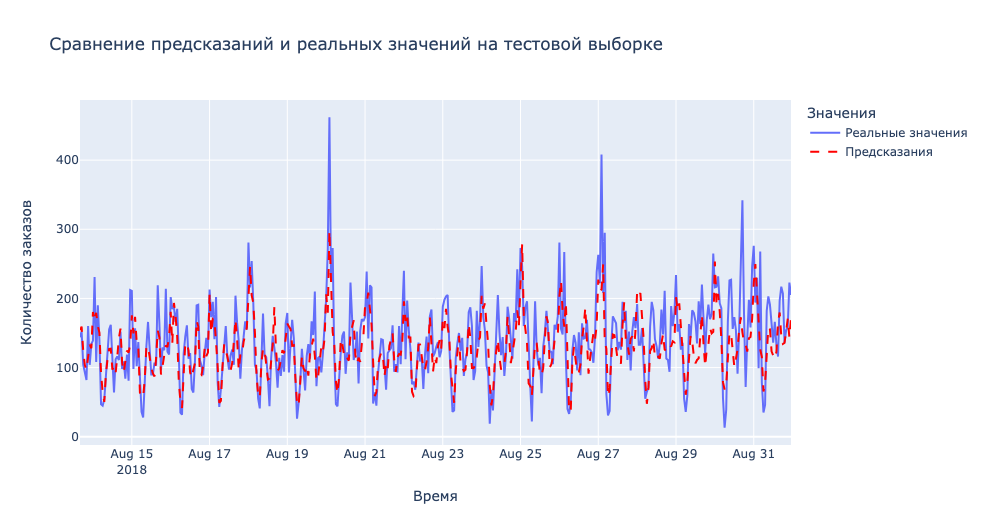

Визуально так и есть — модель хорошо описывает форму распределения, но не угадывает аномальные пики. 
Возможно, эти пики связаны с годовой сезонностью, которую мы не можем увидеть из-за масштаба данных. 
Например, в конце августа  студенты прилетают с каникул из родных городов и эти пики могут быть связаны с ними. 

### Выводы:
Задача исследования состояла в прогнозировании количества заказов такси на следующий час. Нужно было достичь значения метрики RMSE на тестовой выборке не более 48.

В ходе работы было сделано следующее:

- Импортировали и изучили данные: датасет состоял из 26 496 значений, охватывающих период с 1 марта 2018 по 31 августа 2018. Данные были представлены без пропусков и в хронологическом порядке.
- Произвели ресемплирование данных по одному часу и декомпозицию временного ряда на тренд, сезонность и шум. Что позволило выявить ярко выраженную суточную сезонность.
- Провели тест Дики-Фуллера: результаты указали на стационарность ряда с уровнем значимости 5%. хотя визуальный анализ выявил возрастающий тренд. Тем не менее, ряд был рассмотрен как стационарный для дальнейшего предсказания.
- Добавили новые признаки в модель и разделили выборку на три части (обучающую, валидационную и тестовую).
- Протестировали пять моделей с перебором гиперпараметров с использованием метода Байса: `Linear Regression`, `Random Forest`, `XGBRegressor`, `LGBMRegressor` и `CatBoostRegressor`. Оптимизация не привела к значительному улучшению прогноза.
- Лучший результат на валидационных данных был достигнут с помощью модели `CatBoostRegressor`. На тестовых данных эта модель показала `RMSE` равное `39.81`, что соответствует требуемому качеству.
- Визуальное сравнение прогнозов с реальными данными, что модель корректно описывает форму распределения, но не учитывает некоторые пиковые значения.

В результате исследования была построена модель прогнозирования количества заказов такси на следующий час с достаточной точностью, удовлетворяющей требованиям задачи.